In [1]:
# autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys

import torch
import numpy as np
import pandas
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
sys.path.append("applications/align/")

import cv2
from PIL import Image
from mtcnn.detector import detect_faces
from mtcnn.visualization_utils import show_results
from IPython.display import display

/home/kevin/Documents/projects/insightface/mtcnn/first_stage.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(torch.FloatTensor(_preprocess(img)), volatile = True)
/home/kevin/Documents/projects/insightface/mtcnn/get_nets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/home/kevin/Documents/projects/insightface/recognition/arcface_torch/demo.py:81: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_boxes = Variable(torch.FloatTensor(img_boxes), volatile = True)
/home/kevin/Documents/projects/insightface/mtcnn/get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/home/kevin/Documents/projects/insightface/recognition/arcface_torch/demo.py:102: UserWarning: volatile was rem

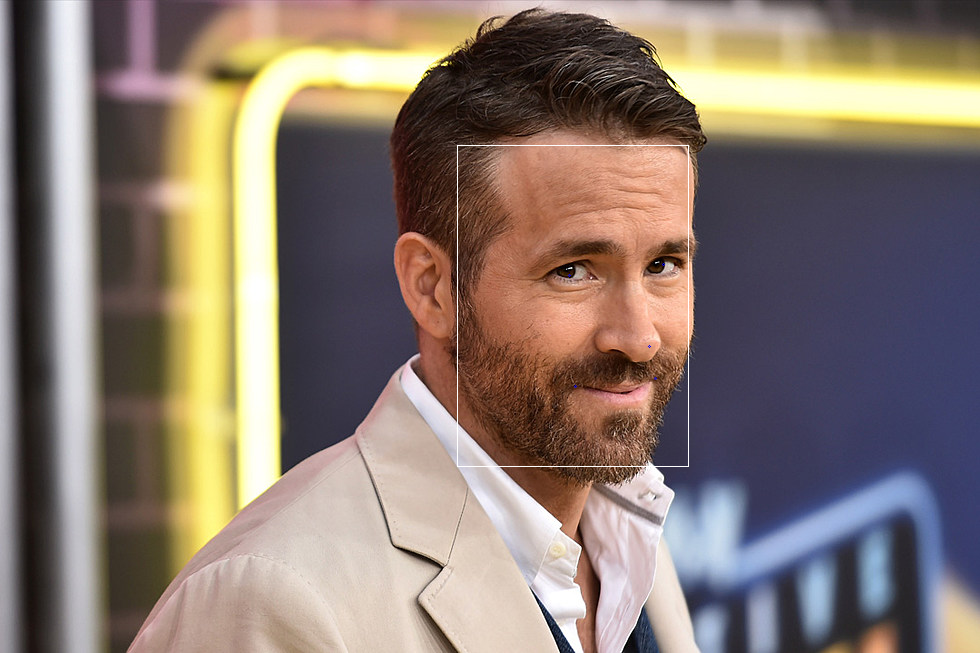

In [20]:
from recognition.arcface_torch.demo import MTCNNFaceDetector

# visualize boxes
img = Image.open('face_test.jpg') # modify the image path to yours
# bounding_boxes, landmarks = detect_faces(img) # detect bboxes and landmarks for all faces in the image
# show_results(img, bounding_boxes, landmarks) # visualize the results

face_det = MTCNNFaceDetector()
bounding_boxes, landmarks = face_det(img)
show_results(img, bounding_boxes, landmarks)

In [4]:
import skimage.transform
def warp_face(img, landmark5):
    SRC = np.array(
        [
            [30.2946, 51.6963],
            [65.5318, 51.5014],
            [48.0252, 71.7366],
            [33.5493, 92.3655],
            [62.7299, 92.2041]]
        , dtype=np.float32)
    SRC[:, 0] += 8.0

    st = skimage.transform.SimilarityTransform()
    st.estimate(landmark5, SRC)
    img = cv2.warpAffine(img, st.params[0:2, :], (112, 112), borderValue=0.0)
    return img

/home/kevin/Documents/projects/insightface/mtcnn/first_stage.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(torch.FloatTensor(_preprocess(img)), volatile = True)
/home/kevin/Documents/projects/insightface/mtcnn/get_nets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/home/kevin/Documents/projects/insightface/mtcnn/detector.py:84: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_boxes = Variable(torch.FloatTensor(img_boxes), volatile = True)
/home/kevin/Documents/projects/insightface/mtcnn/get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
/home/kevin/Documents/projects/insightface/mtcnn/detector.py:105: UserWarning: volatile was removed and now has no effect. Use 

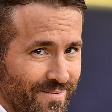

In [5]:
# align
img = np.array(Image.open('face_test.jpg')) # modify the image path to yours
_, landmarks = detect_faces(img)
facial5points = np.array(
    [[landmarks[0][j], landmarks[0][j + 5]] for j in range(5)],
    dtype=np.float32)


warped_face = warp_face(img, facial5points)
display(Image.fromarray(warped_face))

In [6]:
def preproc(img):
    img_1 = np.expand_dims(img, 0)
    img_2 = np.expand_dims(np.fliplr(img), 0)
    output = np.concatenate((img_1, img_2), axis=0).astype(np.float32)
    output = np.transpose(output, (0, 3, 1, 2))
    return output

@torch.no_grad()
def extract_feat_onnx(model, img):
    # model = ArcFaceORT(model_path=model_root)
    # model.check()

    batch = preproc(img)
    # batch = batch.numpy()
    batch = (batch - model.input_mean) / model.input_std
    feat = model.session.run(model.output_names, {model.input_name: batch})[0]
    feat = np.reshape(feat, (-1, model.feat_dim * 2))
    return feat

In [18]:
sys.path.append("recognition/arcface_torch")
from recognition.arcface_torch.demo import ArcFacePredictor

pred = ArcFacePredictor("configs/ms1mv3_r18.py", "weights/arcface/ms1mv3_arcface_r18_fp16.pth")

feat = pred(warped_face)
feat

Loaded checkpoint weights/arcface/ms1mv3_arcface_r18_fp16.pth


array([[-0.00735685, -0.04464231,  0.01225005, ...,  0.00041474,
        -0.0180374 ,  0.02202151]], dtype=float32)

In [16]:
# compute feature
from recognition.arcface_torch.onnx_helper import ArcFaceORT

model = ArcFaceORT(model_path="onnx/arcface/ms1mv3_arcface_r18_fp16")
print(model.check(test_img=img))

features = extract_feat_onnx(model, warped_face)
features = features / np.linalg.norm(features)
features

use onnx-model: onnx/arcface/ms1mv3_arcface_r18_fp16/model.onnx
input-shape: ['None', 3, 112, 112]
0 Conv_0
1 PRelu_1
2 BatchNormalization_2
3 Conv_3
4 PRelu_4
5 Conv_5
6 Conv_6
7 Add_7
max time cost exceed, given 50.8640


2022-07-06 23:17:24.595568505 [W:onnxruntime:, execution_frame.cc:770 VerifyOutputSizes] Expected shape from model of {1,512} does not match actual shape of {32,512} for output 267
2022-07-06 23:17:24.694786545 [W:onnxruntime:, execution_frame.cc:770 VerifyOutputSizes] Expected shape from model of {1,512} does not match actual shape of {2,512} for output 267


array([[-0.00736595, -0.04469127,  0.01219282, ...,  0.00036485,
        -0.01811458,  0.0220085 ]], dtype=float32)